# Volume 4: Solitons

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft

In [11]:
%matplotlib notebook

# Problem 1

Write a function that accepts the time value $t$ (which won't be used here, but will be useful later) the vector $\mathbf{y}=(y_0,y_1,\ldots,y_n,y_{-n-1},\ldots,y_{-1})$ and the vector of $k$ values and returns $\mathbf{y}'$.

In [19]:
# Function for the ODE of the coefficients
def kdv_pseudospectral_ode(t, y, k):
    """
    Given the spectral coefficients y, calculates y'.
    Parameters:
        t (float): The current time
        y ((2n+2,) array): The current spectral coefficients
        k ((2n+2,) array): The vector of wavenumbers
    """
    #equation 1.1: this is the KdV equation
    return ((-1/2)*1j*k)*fft(ifft(y)**2) + (1j*(k**3)*y)

# Problem 2

Write a function that accepts an initial condition `u0`, a final time `T`, the timestep `dt`, an integer `n` for the number of coefficients to use, and another integer `skip`.
Numerically solve for the coefficients $\mathbf{y}(t)$ of a solution to the KdV equation.

Next, convert the Fourier coefficients back into function values at the gridpoints using the inverse Fourier transform.
However, only do this for every `skip`-th timestep; we will be using far more timesteps than we want to plot.
Return the gridpoints, the timesteps, and the solution $u(x,t)$.

In [16]:
# Provided function for integration
def RK4(f, y0, T, dt, k):
    """
    Solves the ODE y'=f(t, y) using the Runge-Kutta 4 method with initial 
    condition y0 on the time interval [0,T] using a time step of dt.
    The value of k is passed directly into the function f.
    
    Returns:
        t ((n_t,) ndarray) - the time values
        Y ((n_t, 2n+2) ndarray) - the solution values. The solution at the 
                i-th time step can be indexed as Y[i].
    """
    # Set up matrices for the solution
    ts = np.arange(0, T+dt, dt)
    Y = np.empty((len(ts),len(k)), dtype=complex)
    y = y0
    Y[0] = y
    for i in range(1, len(ts)):
        # Use RK4
        t = ts[i]
        K1 = f(t, y, k)
        K2 = f(t + dt/2, y + 0.5*dt*K1, k)
        K3 = f(t + dt/2, y + 0.5*dt*K2, k)
        K4 = f(t + dt, y + dt*K3, k)
        y = y + (dt / 6.) * (K1 + 2*K2 + 2*K3 + K4)
        Y[i] = y
    return ts, Y

In [47]:
def solve_kdv(u0, T, dt, n, skip):
    """
    Solve the KdV equation for x in [-pi, pi] and t in [0,T] with the given initial condition.
    
    Parameters:
        u0 - the initial conditions
        T (float) - the final time to solve until
        dt - the time step
        n - the number of points in space to use
        skip - only return every skip-th time step
    
    Returns:
        t ((n_t,) ndarray)
        x ((2n+2,) ndarray)
        u ((n_t, 2n+2) ndarray)
    """
    #(1) numerically solve for coeff y(t) of KdV equation which is problem 1
    #get all components need to plug into RK4 func: f, y0, T, dt, k
    
    #vector of wavenumbers given in lab manual:
    xs = np.linspace(-np.pi, np.pi, 2*n+2)   #want for x in [-pi, pi]
    y0 = fft(u0(xs))                     #formula given on pg 3 of lab manual         
    k = np.concatenate([np.arange(0,n+1),np.arange(-n-1,0)])
    
    ts, Y = RK4(f=kdv_pseudospectral_ode, y0=y0, T=T, dt=dt, k=k)  
    
    #(2) convert Fourier coeff. back into func values @ gridpts using ifft, only do for every skip-th timestep
    #Super Sean helped Jake the Cupcake with this and then Super Sean left to go to bed, but dont worry bc
    #Jake the Cupcake helped me and showed me this super cool fancy indexing trick!
    
    return ts[::skip], xs, np.real(ifft(Y[::skip, :], axis = 1))   #have ::skip, : for Y bc Y is 2D

# Problem 3


Numerically solve the KdV equation on $[−π, π]$ with $n=127$ with initial
conditions
$$
u(x, t = 0) = 3s\,\mathrm{sech}^2
\left(\frac{\sqrt{s}}{2}(x + a)\right),
$$
where $s = 25^2$, $a = 2$. Solve on the time domain $[0, 0.0075]$. 
Plot the solution.
How small of a timestep did you need to use for the numerical integration to be stable?

<IPython.core.display.Javascript object>


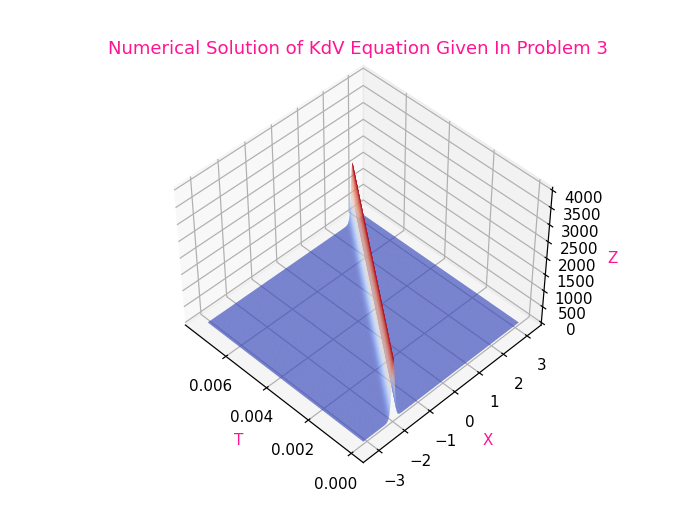

In [58]:
#plug into solve_kdv func from prob 2!
n = 127
s = 25**2
a = 2
T = 0.0075  #T is defined as final time value in time domain
skip = 100  #Super Sean and Jake the Cupcake chose skip to be 100 and it worked out fine for them so why not 
            #for me too!
dt = 1e-7   #I forced Jake the Cupcake to tell me what he used, he gave it up pretty easily YAY

u0 = lambda x: 3*s*(1/np.cosh((np.sqrt(s)/2)*(x+a)))**2  #numpy only has cosh cuz its LAMEO! 

t, x, u = solve_kdv(u0, T, dt, n, skip)

#plot the solution using code given in lab manual:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

T, X = np.meshgrid(t, x, indexing='ij')
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)
plt.title("Numerical Solution of KdV Equation Given In Problem 3", color = "deeppink")
ax.set_xlabel("T", color = "deeppink")
ax.set_ylabel("X", color = "deeppink")
ax.set_zlabel("Z", color = "deeppink")

#given these 3 lines to get similar viewpoint as fig 1.1 in lab manual which we WANT our ans to look like:
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()

plt.show()

For the numerical integration to be stable, I needed to use a timestep of 1e-7.

# Problem 4

Numerically solve the KdV equation on $[−π, π]$. This time we define the initial
condition to be the superposition of two solitons,
$$
u(x,t=0) 
= 3s_1\mathrm{sech}^2\left(\frac{\sqrt{s_1}}{2}(x+a_1)\right) 
+ 3s_2\mathrm{sech}^2\left(\frac{\sqrt{s_2}}{2}(x+a_2)\right),
$$

where $s_1 = 25^2$, $a_1 = 2$, and $s_2 = 16^2$, $a_2 = 1$.
Solve on the time domain $[0, 0.0075]$. 
Plot the solution.

<IPython.core.display.Javascript object>


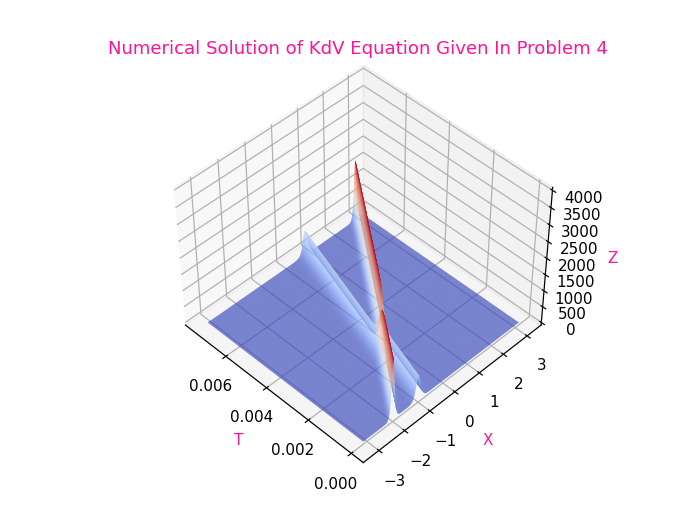

In [62]:
#copy and paste prob 3 and just change some tings, not things, around! 
#plug into solve_kdv func from prob 2!
n = 127
s1 = 25**2
s2 = 16**2
a1 = 2
a2 = 1
T = 0.0075  
skip = 100 
dt = 1e-7   

u0 = lambda x: 3*s1*(1/np.cosh((np.sqrt(s1)/2)*(x+a1)))**2 + 3*s2*(1/np.cosh((np.sqrt(s2)/2)*(x+a2)))**2 

t, x, u = solve_kdv(u0, T, dt, n, skip)

#plot the solution using code given in lab manual:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

T, X = np.meshgrid(t, x, indexing='ij')
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)
plt.title("Numerical Solution of KdV Equation Given In Problem 4", color = "deeppink")
ax.set_xlabel("T", color = "deeppink")
ax.set_ylabel("X", color = "deeppink")
ax.set_zlabel("Z", color = "deeppink")

#given these 3 lines to get similar viewpoint as fig 1.1 in lab manual which we WANT our ans to look like:
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()

plt.show()

# Problem 5

Consider again the ODE for the spectral coefficients.
The linear term in this equation is $i\mathbf{k}^3\mathbf{y}$.
This term contributes much of the exponential growth in the ODE, and contributes to how short the time step must be to ensure numerical stability.
Make the substitution $z_k(t) = e^{-ik^3t}y_k(t)$ and find a similar ODE for $\mathbf{z}$.
This essentially allows the exponential growth to be scaled out (it's solved for analytically, replacing it with rotation in the complex plane).

Use the resulting equation to solve the previous problem.
How much larger of a timestep can you use while this method remains stable?

In [66]:
#changing eq 1.1 which we wrote in prob 1 func so copy that ting down here and make the subsitution!!!
def kdv_pseudospectral_ode_z(t, y, k):
    """
    Given the spectral coefficients y, calculates y'.
    Parameters:
        t (float): The current time
        y ((2n+2,) array): The current spectral coefficients
        k ((2n+2,) array): The vector of wavenumbers
    """
    #find ode for z using subsitution eq given:
    subs = np.exp(1j*(k**3)*t)  #it positive for a reason
    
    return ((-1/2)*1j*k)*fft(ifft(y*(subs))**2)/subs

In [79]:
#supposed rewrite solve_kdv equation from prob 2 to have the z thing in it

def solve_kdv_z(u0, T, dt, n, skip):
    xs = np.linspace(-np.pi, np.pi, 2*n+2)  #keep in here bc will need in cell below 
    y0 = fft(u0(xs))      
    k = np.concatenate([np.arange(0,n+1),np.arange(-n-1,0)])
    
    ts, Z = RK4(f=kdv_pseudospectral_ode_z, y0=y0, T=T, dt=dt, k=k)  #dont forget to use z version of kdv here
    
    Y = np.exp(1j*(k.reshape(1, -1)**3)*ts.reshape(-1, 1))*Z
    
    #no x anymore because when make subs for z and solve it, the x jills itself
    return ts[::skip], np.real(ifft(Y[::skip, :], axis = 1)) 

<IPython.core.display.Javascript object>


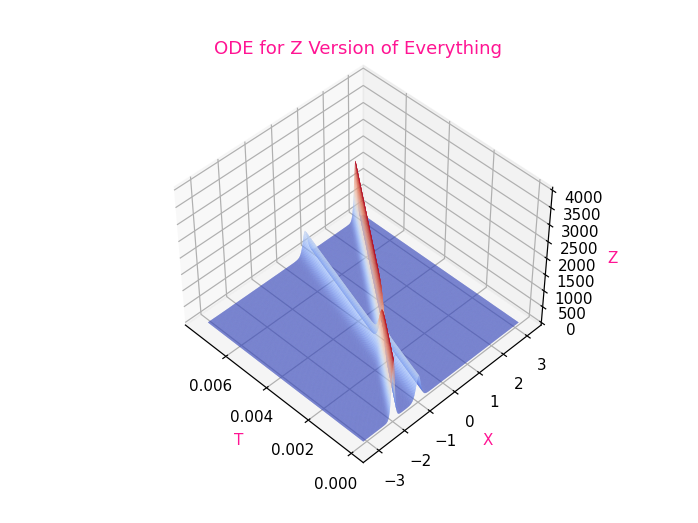

In [81]:
#solve on same problem from problem 4:
n = 127
s1 = 25**2
s2 = 16**2
a1 = 2
a2 = 1
T = 0.0075  
skip = 100 
dt = 1e-7   

u0 = lambda x: 3*s1*(1/np.cosh((np.sqrt(s1)/2)*(x+a1)))**2 + 3*s2*(1/np.cosh((np.sqrt(s2)/2)*(x+a2)))**2 

t, u = solve_kdv_z(u0, T, dt, n, skip)

#plot the solution using code given in lab manual:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

T, X = np.meshgrid(t, x, indexing='ij')
ax.plot_surface(T, X, u, cmap='coolwarm', rstride=1, cstride=1)
plt.title("ODE for Z Version of Everything", color = "deeppink")
ax.set_xlabel("T", color = "deeppink")
ax.set_ylabel("X", color = "deeppink")
ax.set_zlabel("Z", color = "deeppink")

#given these 3 lines to get similar viewpoint as fig 1.1 in lab manual which we WANT our ans to look like:
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()

plt.show()